In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.selection import SmartCorrelatedSelection,DropCorrelatedFeatures

In [3]:
df=pd.read_csv('../../data/data.csv')

In [4]:
df.shape

(41846, 95)

# 1. Drop highly correlated variables

In [5]:
# we have 71 features after detecting the correlation
dcf=DropCorrelatedFeatures(threshold=0.7)
df_drop_correlation=dcf.fit_transform(df)
print(f"Total valid variables number: {df.shape[1]-1}\nDropped features due to correlation: {len(dcf.features_to_drop_)}\nkeep feautures {df_drop_correlation.shape[1]-1}" )

Total valid variables number: 94
Dropped features due to correlation: 23
keep feautures 71


In [6]:
print(f"Correlated groups of features:\n {dcf.correlated_feature_sets_}")

Correlated groups of features:
 [{'discharge_created_datetime', 'Admission_Month'}, {'IP_admission', 'IP_discharge', 'non_elective_admission_flag'}, {'place_of_incident', 'arrival_mode_description', 'source_of_ref_description', 'NEWS2_missing', 'acuity_code', 'ae_unplanned_attendance', 'presenting_complaint_count', 'inj_or_ail', 'location', 'season_of_the_admission', 'presenting_complaint_encoded', 'attendancetype'}, {'comorbidity_acute_myocardial_infarction_flag.1', 'comorbidity_acute_myocardial_infarction_flag'}, {'emergency_readmission_non_pbr_30', 'readmission_flag_28_days_emergancy', 'readmission_flag_30_days_emergancy'}, {'readmission_flag_30_days', 'readmission_flag_28_days'}, {'specialty_spec_code_Surgical_Spec', 'specialty_spec_code_Medical_Spec'}, {'spell_dominant_proc_description', 'spell_dominant_proc_encoded'}, {'spell_primary_diagnosis_description', 'spell_primary_diagnosis_encoded'}, {'ward_code_admission_3', 'ward_code_admission_2'}, {'ward_type_admission', 'ward_type_d

# 2. Feature selection for modelling

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel,SelectKBest
from sklearn.model_selection import train_test_split

In [36]:
#train test split for feature selection
X=df_drop_correlation.drop('spell_length_of_stay_hours',axis=1)
y_orgin=df_drop_correlation['spell_length_of_stay_hours']
# clips y by capping all values above its 99th percentile to that percentile value (627) to handle the extrem cases.
y_cliped = np.clip(y_orgin, None, y_orgin.quantile(0.95))
#transformtion
y_transfromed = np.log1p(y_cliped)
X_train, X_test, y_train, y_test=train_test_split(X,y_transfromed,test_size=0.2, random_state=42)

In [10]:
y_cliped.describe()

count    41846.000000
mean        35.935239
std         62.966064
min          0.000000
25%          3.000000
50%          6.000000
75%         34.000000
max        239.000000
Name: spell_length_of_stay_hours, dtype: float64

Text(0.5, 1.0, 'length of stay hours (log1p transformation)')

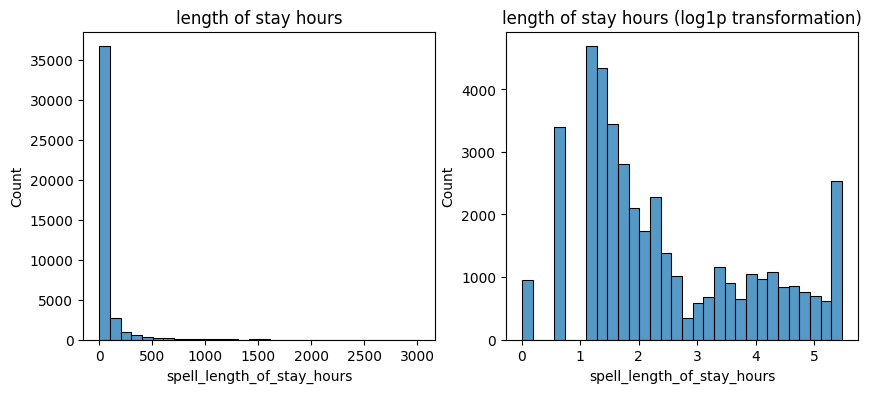

In [13]:
fig,axes=plt.subplots(1,2,figsize=(10,4))
sns.histplot(y_orgin,ax=axes[0], bins=30)
sns.histplot(y_transfromed,ax=axes[1], bins=30)
axes[0].set_title('length of stay hours')
axes[1].set_title('length of stay hours (log1p transformation)')

In [14]:
# using random forest for feature selection
sel_=SelectFromModel(RandomForestRegressor(n_estimators=10,random_state=10))
sel_.fit(X_train,y_train)

,estimator,RandomForestR...ndom_state=10)
,threshold,None
,prefit,False
,norm_order,1
,max_features,None
,importance_getter,'auto'
,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1


In [15]:
#there 15 features are high significant effect on y label
selected_f=X_train.columns[(sel_.get_support())]
print(f'{len(selected_f)} features are selected,\nthey are {selected_f}')

15 features are selected,
they are Index(['patient_age_on_admission', 'Admission_Hour', 'ward_code_admission_2',
       'spell_dominant_proc_count', 'spell_secondary_diagnosis_encoded',
       'spec_direc_Womens Health', 'hrg_sub_group_encoded',
       'general_medical_practice_desc', 'IP_admission', 'ward_type_admission',
       'spell_primary_diagnosis_description',
       'spell_dominant_proc_description', 'discharge_letter_status',
       'comorbidity_score', 'NEWS2_missing'],
      dtype='object')


**check the correlation relationship with y label**

In [16]:
corr_with_y = X_train[selected_f].corrwith(y_train)

In [17]:
corr_sorted = corr_with_y.sort_values(ascending=False)
print(corr_sorted)

IP_admission                           0.513988
spell_secondary_diagnosis_encoded      0.449396
spell_primary_diagnosis_description    0.437281
spell_dominant_proc_description        0.405424
hrg_sub_group_encoded                  0.310789
discharge_letter_status                0.282782
comorbidity_score                      0.262378
spec_direc_Womens Health               0.220033
Admission_Hour                         0.114538
spell_dominant_proc_count              0.114441
general_medical_practice_desc          0.039308
ward_type_admission                    0.032188
patient_age_on_admission               0.011009
ward_code_admission_2                 -0.211567
NEWS2_missing                         -0.452329
dtype: float64


Text(0.5, 0, 'Feature importance')

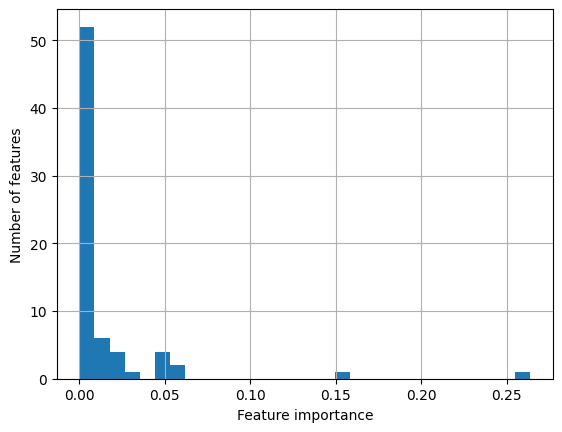

In [18]:
#check the importance variables distribution
ss=pd.Series(sel_.estimator_.feature_importances_.ravel())
ss.hist(bins=30)
plt.ylabel("Number of features")
plt.xlabel('Feature importance')

**The top 15 variables that have significant effect on target variable based on feature importance score**

In [19]:
#order the variables by Feature importance score
df_f_importance=pd.DataFrame({

    'feature_name':X_train.columns,
    'Feature_importance':sel_.estimator_.feature_importances_.ravel()
}
    )
df_f_importance=df_f_importance.sort_values(by='Feature_importance',ascending=False)
df_f_importance.head(15)

,feature_name,Feature_importance
38,IP_admission,0.263797
40,spell_primary_diagnosis_description,0.149847
6,Admission_Hour,0.060558
70,NEWS2_missing,0.056771
15,spell_dominant_proc_count,0.050992
43,discharge_letter_status,0.049863
41,spell_dominant_proc_description,0.047107
1,patient_age_on_admission,0.044203
19,spell_secondary_diagnosis_encoded,0.032226
39,ward_type_admission,0.023686


# 3. Modelling

## XGboost & Random Forest

In [49]:
import xgboost as xgb
from sklearn.model_selection import KFold,cross_val_score
from sklearn.ensemble import RandomForestRegressor
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats

**Summary**
- Train both XGboost and Random Forest(RF), I found the xgboost perform better compared to RF, and the best hyperparameters are:
- 'n_estimators': 551, 'eta': 0.09999505543790956, 'max_depth': 4, 'min_child_weight': 7, 'gamma': 0.007863761012372683, 'subsample': 0.9073633957366012, 'colsample_bytree': 0.9023232725358237, 'lambda': 0.4625447729034002, 'alpha': 5.622304574316678}

In [ ]:
X_train = np.array(X_train[selected_f])
y_train = np.array(y_train)
X_test = np.array(X_test[selected_f])
y_test = np.array(y_test)

**Tune the parameters by using top 15 features**

In [78]:
def objective(trial):

    
    model_name = trial.suggest_categorical("model", ["xgb", "rf"])

    
    n_estimators = trial.suggest_int("n_estimators", 300, 600)

    # =====================================================
    #  1：XGBoost
    # =====================================================
    if model_name == "xgb":


        params = {
            "objective": "reg:squarederror",
            "tree_method": "hist",
            
            "eta": trial.suggest_float("eta", 0.01, 0.1),
            "max_depth": trial.suggest_int("max_depth", 2, 4),
            "min_child_weight": trial.suggest_int("min_child_weight", 3, 15),
            "gamma": trial.suggest_float("gamma", 0.0, 10.0),

            "subsample": trial.suggest_float("subsample", 0.7, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),

            "reg_lambda": trial.suggest_float("lambda", 0.1, 10.0, log=True),
            "reg_alpha": trial.suggest_float("alpha", 0.1, 10.0, log=True),

            "n_estimators": n_estimators,
            "random_state": 42,
        }

        model = xgb.XGBRegressor(**params)

    # =====================================================
    #  2：RandomForest
    # =====================================================
    else:

        params = {
            "n_estimators": n_estimators,
            "max_depth": trial.suggest_int("max_depth_rf", 3, 5),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        }

        model = RandomForestRegressor(
            **params,
            random_state=42,
            n_jobs=-1
        )

    # =====================================================
    #   cross validation, target: minimum MAE
    # =====================================================
    mae = -cross_val_score(
        model,
        X_train, y_train,
        scoring="neg_mean_absolute_error",
        cv=5,
        n_jobs=-1
    ).mean()

    return mae


# =====================================================
#  run optuna and start to tune hyperparameter 
# =====================================================
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300)

print("Best model:", study.best_params["model"])
print("Best params:", study.best_params)
print("Best MAE:", study.best_value)

[I 2025-12-09 23:50:24,116] A new study created in memory with name: no-name-2c9a8e72-3323-47ab-95f1-708bf6e18834
[I 2025-12-09 23:50:49,360] Trial 0 finished with value: 0.7094056646450448 and parameters: {'model': 'rf', 'n_estimators': 499, 'max_depth_rf': 4, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.7094056646450448.
[I 2025-12-09 23:50:57,179] Trial 1 finished with value: 0.6178398535225568 and parameters: {'model': 'xgb', 'n_estimators': 593, 'eta': 0.029845622123820886, 'max_depth': 2, 'min_child_weight': 9, 'gamma': 9.030543719035483, 'subsample': 0.9685513183552277, 'colsample_bytree': 0.9642888843200249, 'lambda': 0.4690242488720859, 'alpha': 0.3345874253816728}. Best is trial 1 with value: 0.6178398535225568.
[I 2025-12-09 23:51:04,758] Trial 2 finished with value: 0.5782766205142365 and parameters: {'model': 'xgb', 'n_estimators': 328, 'eta': 0.0150593799054111, 'max_depth': 4, 'min_child_weight': 6

Best model: xgb
Best params: {'model': 'xgb', 'n_estimators': 551, 'eta': 0.09999505543790956, 'max_depth': 4, 'min_child_weight': 7, 'gamma': 0.007863761012372683, 'subsample': 0.9073633957366012, 'colsample_bytree': 0.9023232725358237, 'lambda': 0.4625447729034002, 'alpha': 5.622304574316678}
Best MAE: 0.5263311646735536


In [84]:
# tuning result, best hyperparameter combination
best_params = {
    'n_estimators': 551,
    'eta': 0.09999505543790956,
    'max_depth': 4,
    'subsample': 0.9073633957366012,
    'colsample_bytree': 0.9023232725358237,
    'min_child_weight': 7,
    'lambda': 0.4625447729034002,
    'alpha': 5.622304574316678,
    'gamma': 0.007863761012372683 
}

# train xgb model
best_model = xgb.XGBRegressor(
    **best_params,
    random_state=42
)

best_model.fit(X_train, y_train)
print("Model training completed!")


# ==========================
# train data set prediction
# ==========================
y_train_pred_log = best_model.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_true = np.expm1(y_train)

train_mae = mean_absolute_error(y_train_true, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))


# ==========================
# test data set prediction
# ==========================
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

test_mae = mean_absolute_error(y_true, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_true, y_pred))


print("=======Training Set Performance=======")
print("Train MAE :", train_mae)
print("Train RMSE:", train_rmse)

print("\n=======Test Set Performance=======")
print("Test MAE :", test_mae)
print("Test RMSE:", test_rmse)

print("\n======MAE & RMSE Increase Percentage On Test dataset========")
print("MAE Increase Percentage:", round((test_mae-train_mae)/train_mae*100,2),"%")
print("RMSE Increase Percentage:", round((test_rmse-train_rmse)/train_rmse*100,2),"%")

Model training completed!
=======Training Set Performance=======
Train MAE : 17.682420651300344
Train RMSE: 40.406710338560536

=======Test Set Performance=======
Test MAE : 20.340178665666865
Test RMSE: 46.02946800277712

======MAE & RMSE Increase Percentage On Test dataset========
MAE Increase Percentage: 15.03 %
RMSE Increase Percentage: 13.92 %


# 4. Model Evaluation

In [72]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

mean_y = y_true.mean()
median_y = np.median(y_true)

print("MAE:", mae)
print("RMSE:", rmse)
print("mean(y):", mean_y)
print("median(y):", median_y)
print("std(y):", y_true.std())
print("MAE / mean(y):", mae / mean_y)
print("RMSE / mean(y):", rmse / mean_y)

MAE: 20.223602515787515
RMSE: 46.19534876605939
mean(y): 36.54862604540024
median(y): 5.999999999999999
std(y): 64.11566488601152
MAE / mean(y): 0.5533341387625902
RMSE / mean(y): 1.2639421440542282


In [61]:
# baseline prediction
y_pred_mean = np.full_like(y_true, fill_value=mean_y, dtype=float)

y_pred_median = np.full_like(y_true, fill_value=median_y, dtype=float)

for name, pred in [("mean", y_pred_mean), ("median", y_pred_median), ("model", y_pred)]:
    mae_ = mean_absolute_error(y_true, pred)
    rmse_ = np.sqrt(mean_squared_error(y_true, pred))
    print(f"{name:>6} -> MAE = {mae_:.3f}, RMSE = {rmse_:.3f}")


  mean -> MAE = 45.123, RMSE = 64.116
median -> MAE = 33.605, RMSE = 71.021
 model -> MAE = 20.224, RMSE = 46.195


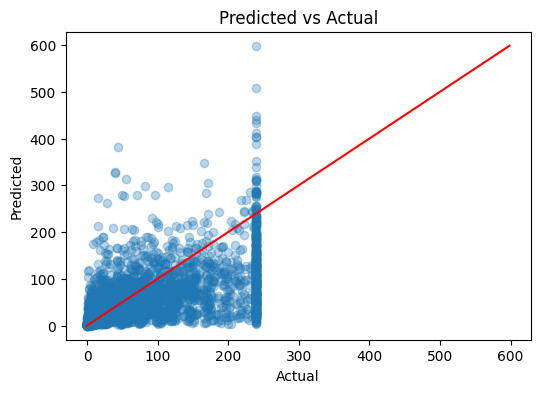

In [63]:

plt.figure(figsize=(6,4))
plt.scatter(y_true, y_pred, alpha=0.3)
min_v = min(y_true.min(), y_pred.min())
max_v = max(y_true.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], color="red") 

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()


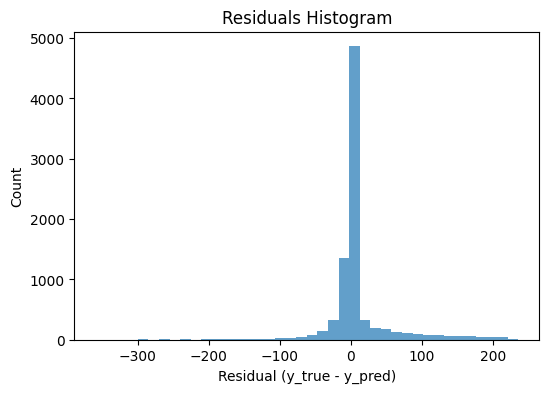

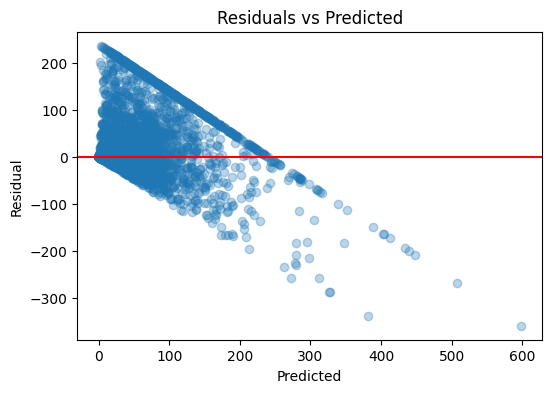

In [76]:
residuals = y_true - y_pred
# Residuals Histogram
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40, alpha=0.7)
plt.title("Residuals Histogram")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Count")
plt.show()

# Residuals vs predicted 
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color="red")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.show()

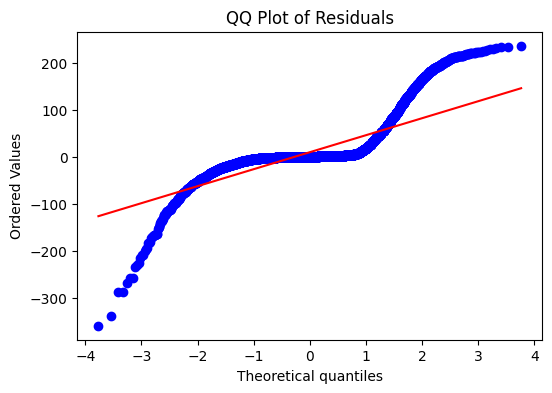

In [69]:
#QQ plot of Residuals
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()